### DOM tree construction

Need to construct a heirarchial tree from the resume document. The resume document is in the form of line boxes which have their corresponding font size and sequence listed in the form of an array. 

```html
<h1>Akshay Sehgal</h1>

<p>This is my resume document. I have a detailed overview here.</p>


<h2>Education</h2> 

<p>Education details...</p>

... and so on.

```

The above PDF structure now becomes, [33, 0, 14, 0, 0, 27, 13, ....] . This is an array of font sizes of starting character for each line.

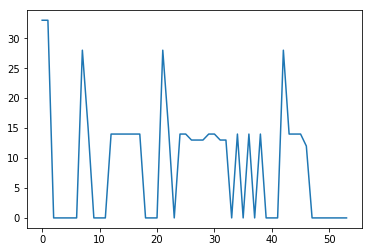

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x_orig = [33,33,0,0,0,0,0,28,15,0,0,0,14,14,14,14,14,14,0,0,0,28,15,0,14,14,13,13,13,14,14,13,13,0,14,0,14,0,14,0,0,0,28,14,14,14,12,0,0,0,0,0,0,0]

plt.plot(x_orig)

(I could break this into sub sequences and tag each with a certain type of text structure, e.g. the section around 30 is a table as it has text followed by subpoints which are 1 font size smaller and this repeats 2 times. Then I could used a classifier to remember these individual patterns and get it to segment a given signal into these signals based on the probability of text structures (tables, paragraphs, bullet points, separated lines, headings, etc.) it can predict.

But its too complex and maybe have issues from the points of view of training data that needs to be tagged for it. So ill skip this approach.

Lets used a gmm to separate out the underlying distributions. The assumption is that there should be 3 -4 different levels in our heirarchial tree, meaning there would be about 3-4 major steps in font size of the document. Lets use GMM to find these.

54


/Users/akshay/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


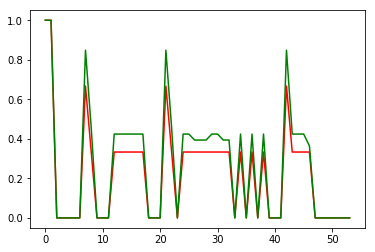

In [34]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler


x_np = np.array(x_orig).reshape(len(x_orig),1)
print(len(x_np))

n = 4
gmm = GaussianMixture(n_components=n)
gmm.fit(x_np)

gmm_dist = gmm.predict(x_np).reshape(len(x_orig),1)

mms = MinMaxScaler()
plt.plot(mms.fit_transform(gmm_dist),'r')
plt.plot(mms.fit_transform(x_np),'g')

#Rerun a few times until both curves fit, if they dont at start

This plot will sometimes look wierd or almost like 2 mirror graphs because gmm labels its clusters randomly, but when they are ascending like the font size, they match perfectly as above. 

Incase examples of the signals have too much fluctuation in them, i can smoothen the distribution a little by using RDP. There would fix many of the small variations such as font 14 & 13 close together. But ill skip the process for now.

Lets keep a master df for keeping track of all transformed variations of the x_orig, and any predicted stuff

In [56]:
import pandas as pd

df = pd.DataFrame({'font_orig':list(x_orig),
                   'gmm_pred':[i for sublist in list(gmm_dist) for i in sublist]
                  })
df.head(10)

,font_orig,gmm_pred
0,33,3
1,33,3
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,28,2
8,15,1
9,0,0


So now, i can transform the current sequence which has variation into this GMM predicted cluster based sequence where I maintain only the font sizes that match

In [78]:
def font_fixed(df):
    a = df.groupby(['gmm_pred'])['font_orig'].mean().reset_index()
    a.columns = ['gmm_pred','font_avg']
    b = df.merge(a,on='gmm_pred',how='left').set_index(df.index)
    return b

df1 = font_fixed(df)
df1.head(10)

,font_orig,gmm_pred,font_avg
0,33,3,33.000000
1,33,3,33.000000
2,0,0,0.000000
3,0,0,0.000000
4,0,0,0.000000
5,0,0,0.000000
6,0,0,0.000000
7,28,2,28.000000
8,15,1,13.791667
9,0,0,0.000000


Now lets one hot encode the font_avg variable to get a virtual grid of the font based heirarchy of the document. And lets remove zeros as well.

In [103]:
df2 = pd.get_dummies(df1,columns=['font_avg'])

new_col_labels = list(reversed(['h'+str(i+1) for i in range(n)]))

df2.columns = list(df1.columns)[:-1] + new_col_labels
df3 = df2[df2['font_orig']!=0]
df3.head(10)

,font_orig,gmm_pred,h4,h3,h2,h1
0,33,3,0,0,0,1
1,33,3,0,0,0,1
7,28,2,0,0,1,0
8,15,1,0,1,0,0
12,14,1,0,1,0,0
13,14,1,0,1,0,0
14,14,1,0,1,0,0
15,14,1,0,1,0,0
16,14,1,0,1,0,0
17,14,1,0,1,0,0


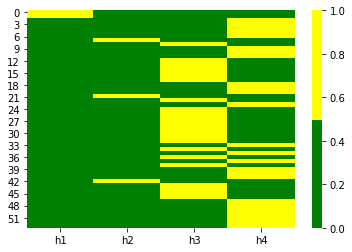

In [102]:
import seaborn as sns
from matplotlib.colors import ListedColormap

sns.heatmap(df2[list(reversed(new_col_labels))],cmap=ListedColormap(['green', 'yellow']))

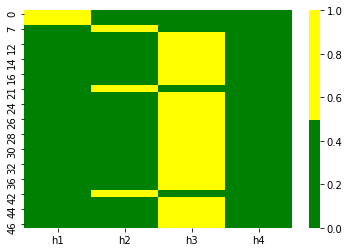

In [104]:
sns.heatmap(df3[list(reversed(new_col_labels))],cmap=ListedColormap(['green', 'yellow']))